In [390]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
Data = pd.read_csv('healthcare-dataset-stroke-data.csv')

print(Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


Nulls in bmi:  201


<Axes: >

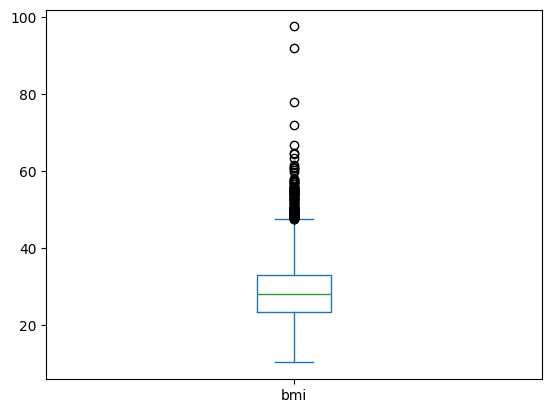

In [391]:
print("Nulls in bmi: ", Data['bmi'].isnull().sum())
Data['bmi'].plot(kind='box')

The BMI column is right-skewed: most people have BMI around 20–30, but a small number of individuals with very high BMI create a long right tail. Therefore, median is a better measure of central tendency because of the outliers

Text(0, 0.5, 'Average bmi')

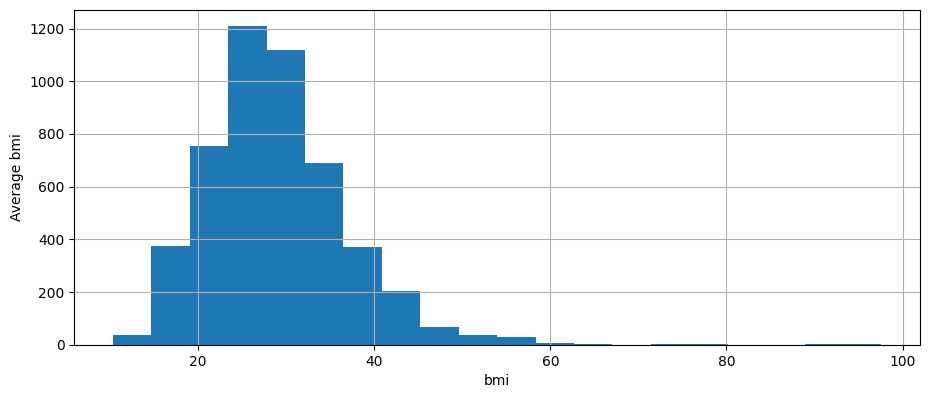

In [392]:
plt.figure(figsize=(24,20))


plt.subplot(4, 2, 1)
fig = Data['bmi'].hist(bins=20)
fig.set_xlabel('bmi')
fig.set_ylabel('Average bmi')

In [393]:
Data['bmi'] = Data['bmi'].fillna(Data['bmi'].median())
plt.figure(figsize=(24,20))

Data['bmi'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5110 entries, 0 to 5109
Series name: bmi
Non-Null Count  Dtype  
--------------  -----  
5110 non-null   float64
dtypes: float64(1)
memory usage: 40.1 KB


<Figure size 2400x2000 with 0 Axes>

REMOVING 'Other' value from the 'gender' feature, and DROPPING the 'id' feature

In [394]:
Data = Data.drop('id', axis='columns')
Data[Data['gender'] == 'Other']
Data = Data.drop(Data[Data['gender'] == 'Other'].index)

DUE TO THAT 'Unknown' VALUE IS 1544 WHICH IS THE THIRD OF OUR DATASET
WE CANNOT ASSIGN 'Unkown' to be 'never smoked'(median)
BECAUSE THAT WILL LEAD TO OVERFITTNIG, SO WE WILL LEAVE IT 

In [395]:
Data['smoking_status'].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64

In [396]:

Data['gender'] = Data['gender'].map({'Male' : 1, 'Female' : 0})
Data['Residence_type'] = Data['Residence_type'].map({'Urban' : 1, 'Rural' : 0})
Data['ever_married'] = Data['ever_married'].map({'Yes' : 1, 'No' : 0})

Data = pd.get_dummies(
    Data,
    columns=['work_type', 'smoking_status'],
    drop_first=False
).astype(int)

Data['stroke'].value_counts() #Imbalanced target

stroke
0    4860
1     249
Name: count, dtype: int64

stroke
1    4860
0    4860
Name: count, dtype: int64


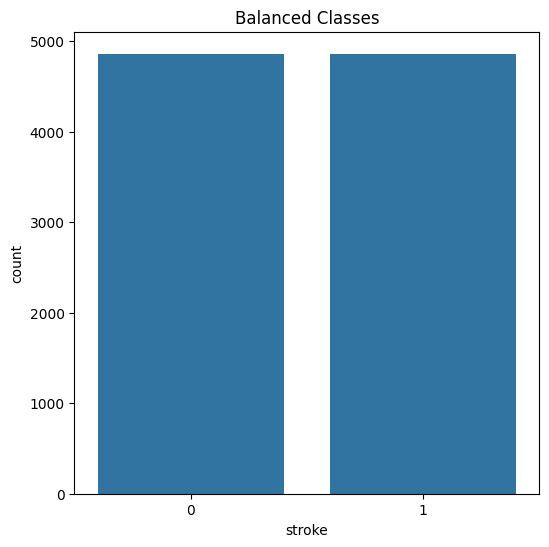

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9720 entries, 0 to 9719
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   gender                          9720 non-null   int32
 1   age                             9720 non-null   int32
 2   hypertension                    9720 non-null   int32
 3   heart_disease                   9720 non-null   int32
 4   ever_married                    9720 non-null   int32
 5   Residence_type                  9720 non-null   int32
 6   avg_glucose_level               9720 non-null   int32
 7   bmi                             9720 non-null   int32
 8   work_type_Govt_job              9720 non-null   int32
 9   work_type_Never_worked          9720 non-null   int32
 10  work_type_Private               9720 non-null   int32
 11  work_type_Self-employed         9720 non-null   int32
 12  work_type_children              9720 non-null   int32
 13  smo

In [397]:
x = Data.drop('stroke', axis=1)
y = Data['stroke']

sm = SMOTE()
X_oversampled, y_oversampled = sm.fit_resample(x, y)

print(y_oversampled.value_counts())

plt.figure(figsize=(6, 6))
sns.countplot(x = y_oversampled, data = Data)
plt.title('Balanced Classes')
plt.show();

print(X_oversampled.info())

In [398]:
x_train, x_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.3, stratify=y_oversampled, shuffle=True, random_state=42)

scaler = MinMaxScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

np.random.seed(42)

logistic_model=LogisticRegression()

logistic_model.fit(x_train_scaled,y_train)

y_pred_log_reg=logistic_model.predict(x_test_scaled)

print(classification_report(y_test,y_pred_log_reg));

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1458
           1       0.95      0.89      0.92      1458

    accuracy                           0.92      2916
   macro avg       0.92      0.92      0.92      2916
weighted avg       0.92      0.92      0.92      2916



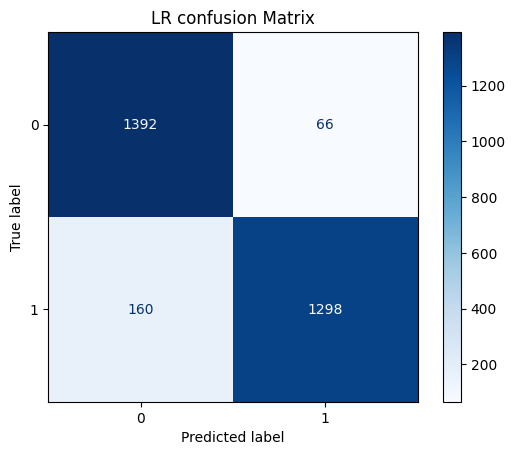

In [399]:
cm = confusion_matrix(y_test, y_pred_log_reg)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("LR confusion Matrix")
plt.show()

In [400]:
# Configure and train SVC
svc = SVC(
    C=1.0,
    kernel='rbf',       # radial basis function kernel (good default)
    gamma='scale',      # automatic gamma
    class_weight='balanced',  # helps with class imbalance
    probability=True,   # enables predict_proba (slower but needed for ROC)
    random_state=42
)

svc.fit(x_train_scaled, y_train)
y_pred_svc = svc.predict(x_test_scaled)

print(classification_report(y_test,y_pred_svc))


              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1458
           1       0.97      0.88      0.93      1458

    accuracy                           0.93      2916
   macro avg       0.93      0.93      0.93      2916
weighted avg       0.93      0.93      0.93      2916



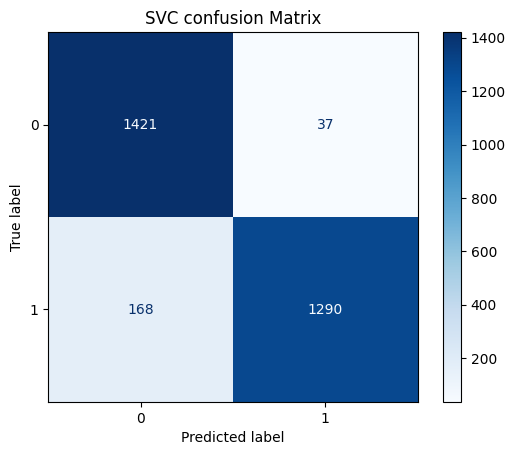

In [401]:
cm = confusion_matrix(y_test, y_pred_svc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("SVC confusion Matrix")
plt.show()